# Problem Statement

###### Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.
##### We will be using collaborative filtering

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings


C:\Users\Sharat\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Reading dat files

In [10]:
movies = pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')

In [11]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [12]:
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [13]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


## Formatting Data Files

In [14]:
movies.drop(columns=['Unnamed: 1', 'Unnamed: 2'], inplace=True)

In [15]:
# Split the existing column into three separate columns
movies[['Movie ID', 'Title', 'Genres']] = movies['Movie ID::Title::Genres'].str.split('::', expand=True)

# Drop the original column
movies.drop(columns=['Movie ID::Title::Genres'], inplace=True)

# Display the modified datafr
movies.head()


,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
# Split the existing column into four separate columns
ratings[['UserID', 'MovieID', 'Rating', 'Timestamp']] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::', expand=True)

# Drop the original column
ratings.drop(columns=['UserID::MovieID::Rating::Timestamp'], inplace=True)



In [18]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [19]:
# Split the existing column into five separate columns
users[['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::', expand=True)

# Drop the original column
users.drop(columns=['UserID::Gender::Age::Occupation::Zip-code'], inplace=True)




In [21]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [22]:
# Replace numerical codes with categorical values for Gender
users['Gender'] = users['Gender'].replace({'M': 'Male', 'F': 'Female'})

# Replace numerical codes with categorical values for Age
age_mapping = {
    '1': 'Under 18',
    '18': '18-24',
    '25': '25-34',
    '35': '35-44',
    '45': '45-49',
    '50': '50-55',
    '56': '56+'
}
users['Age'] = users['Age'].replace(age_mapping)

# Replace numerical codes with categorical values for Occupation
occupation_mapping = {
    '0': 'Other or not specified',
    '1': 'Academic/Educator',
    '2': 'Artist',
    '3': 'Clerical/Admin',
    '4': 'College/Grad Student',
    '5': 'Customer Service',
    '6': 'Doctor/Health Care',
    '7': 'Executive/Managerial',
    '8': 'Farmer',
    '9': 'Homemaker',
    '10': 'K-12 Student',
    '11': 'Lawyer',
    '12': 'Programmer',
    '13': 'Retired',
    '14': 'Sales/Marketing',
    '15': 'Scientist',
    '16': 'Self-Employed',
    '17': 'Technician/Engineer',
    '18': 'Tradesman/Craftsman',
    '19': 'Unemployed',
    '20': 'Writer'
}
users['Occupation'] = users['Occupation'].replace(occupation_mapping)



In [23]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,Female,Under 18,K-12 Student,48067
1,2,Male,56+,Self-Employed,70072
2,3,Male,25-34,Scientist,55117
3,4,Male,45-49,Executive/Managerial,02460
4,5,Male,25-34,Writer,55455


In [24]:
# Check the shape of the dataframe
print("Movies dataframe shape:", movies.shape)

# Check the information of the dataframe
print("\nMovies dataframe information:")
print(movies.info())


Movies dataframe shape: (3883, 3)

Movies dataframe information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3883 non-null   object
 1   Title     3883 non-null   object
 2   Genres    3858 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB
None


In [25]:
# Check the shape of the dataframe
print("Ratings dataframe shape:", ratings.shape)

# Check the information of the dataframe
print("\nRatings dataframe information:")
print(ratings.info())


Ratings dataframe shape: (1000209, 4)

Ratings dataframe information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB
None


In [26]:
# Check the shape of the dataframe
print("Users dataframe shape:", users.shape)

# Check the information of the dataframe
print("\nUsers dataframe information:")
print(users.info())


Users dataframe shape: (6040, 5)

Users dataframe information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB
None


In [27]:
# Merge the ratings and movies dataframes on the common column 'MovieID' using an inner join
#merged_df = pd.merge(movies, ratings, on='MovieID', how='inner')

# Display the merged dataframe
#(merged_df.head())


KeyError: 'MovieID'

In [28]:
# Rename the 'Movie ID' column to 'MovieID' without spaces in the movies dataframe
movies.rename(columns={'Movie ID': 'MovieID'}, inplace=True)



## Merging data files into single Dataframe

In [29]:
# Merge the ratings and movies dataframes on the common column 'MovieID' using an inner join
merged_df = pd.merge(movies, ratings, on='MovieID', how='inner')

# Display the merged dataframe
(merged_df.head())


,MovieID,Title,Genres,UserID,Rating,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [30]:
# Merge the merged_df and users dataframes on the common column 'UserID' using an inner join
final_df = pd.merge(merged_df, users, on='UserID', how='inner')

# Display the final merged dataframe
(final_df.head())


,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,Female,Under 18,K-12 Student,48067
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,Female,50-55,Homemaker,55117
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,Male,25-34,Programmer,11413
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,Male,25-34,Technician/Engineer,61614
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,Female,35-44,Academic/Educator,95370


## Reviewing shape and structure

In [31]:
final_df.shape

(1000209, 10)

In [32]:
# Make a copy of the merged dataframe
final_df_copy = final_df.copy()

In [33]:
final_df_copy.sample(10)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
289409,1177,Enchanted April (1991),Drama,3611,4,966614836,Male,25-34,Artist,84321
420689,1429,Jackie Chan's First Strike (1996),Action,3684,5,966350143,Male,25-34,Technician/Engineer,83713
774420,2879,Operation Condor (Feiying gaiwak) (1990),Action|Adventure|Comedy,4489,4,983304003,Male,18-24,College/Grad Student,78613
56443,208,Waterworld (1995),Action|Adventure,4156,3,965342068,Male,56+,Writer,95123
502884,1873,"Misérables, Les (1998)",Drama,2692,5,973318362,Female,18-24,College/Grad Student,14620
396994,1370,Die Hard 2 (1990),Action|Thriller,668,3,975635187,Female,25-34,Clerical/Admin,22042
697980,2596,SLC Punk! (1998),Comedy|Drama,3834,5,966396625,Male,18-24,Artist,02322
120533,446,Farewell My Concubine (1993),Drama|Romance,1052,4,974956663,Female,35-44,Artist,75214
615169,2282,Pecker (1998),Comedy|Drama,4447,4,965175344,Male,45-49,Customer Service,32953
695529,2574,"Out-of-Towners, The (1999)",Comedy,2116,4,974650867,Male,18-24,College/Grad Student,49546


In [34]:
final_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      996144 non-null   object
 3   UserID      1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Timestamp   1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  object
 8   Occupation  1000209 non-null  object
 9   Zip-code    1000209 non-null  object
dtypes: object(10)
memory usage: 76.3+ MB


## Performing necessary type conversion and deriving new features

In [35]:
final_df_copy['Rating'] = final_df_copy['Rating'].astype('int32')


In [36]:
# Convert the 'Timestamp' column to datetime format
final_df_copy['Datetime'] = pd.to_datetime(final_df_copy['Timestamp'], unit='s')

C:\Users\Sharat\AppData\Local\Temp\ipykernel_45892\3752505912.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  final_df_copy['Datetime'] = pd.to_datetime(final_df_copy['Timestamp'], unit='s')


In [37]:
warnings.simplefilter('ignore')

In [38]:
# Extract the release year from the 'Title' column and create a new 'ReleaseYear' column
final_df_copy['ReleaseYear'] = final_df_copy['Title'].str.extract(r'\((\d{4})\)')

In [40]:
final_df_copy['ReleaseYear'].unique().sort_values()

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

In [41]:
# Print unique values in the 'ReleaseYear' column in ascending order
print("Unique Release Years (Ascending Order):", sorted(final_df_copy['ReleaseYear'].dropna().unique().astype(int)))


Unique Release Years (Ascending Order): [1919, 1920, 1921, 1922, 1923, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000]


In [42]:
final_df_copy

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,Female,Under 18,K-12 Student,48067,2001-01-06 23:37:36,1995
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,Female,50-55,Homemaker,55117,2000-12-31 04:29:52,1995
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,Male,25-34,Programmer,11413,2000-12-31 03:31:12,1995
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,Male,25-34,Technician/Engineer,61614,2000-12-31 01:25:20,1995
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,Female,35-44,Academic/Educator,95370,2000-12-31 01:34:56,1995
...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,3952,"Contender, The (2000)",Drama|Thriller,5812,4,992072099,Female,25-34,Executive/Managerial,92120,2001-06-09 07:35:28,2000
1000205,3952,"Contender, The (2000)",Drama|Thriller,5831,3,986223125,Male,25-34,Academic/Educator,92120,2001-04-02 14:51:44,2000
1000206,3952,"Contender, The (2000)",Drama|Thriller,5837,4,1011902656,Male,25-34,Executive/Managerial,60607,2002-01-24 20:04:16,2000
1000207,3952,"Contender, The (2000)",Drama|Thriller,5927,1,979852537,Male,35-44,Sales/Marketing,10003,2001-01-18 21:15:44,2000


In [43]:
# Drop rows where 'ReleaseYear' is NaN
final_df_copy.dropna(subset=['ReleaseYear'], inplace=True)

In [44]:
# Change the data type of 'ReleaseYear' column to int32
final_df_copy['ReleaseYear'] = final_df_copy['ReleaseYear'].astype('int32')

In [45]:
# Extract the titles of the movies from the 'Title' column
final_df_copy['Title'] = final_df_copy['Title'].str.split(' \(', n=1, expand=True)[0]

In [48]:
# Define a function to map release years to decades
def map_to_decade(year):
    if year > 1920 and year <= 1930:
        return '20s'
    elif year > 1930 and year <= 1940:
        return '30s'
    elif year > 1940 and year <= 1950:
        return '40s'
    elif year > 1950 and year <= 1960:
        return '50s'
    elif year > 1960 and year <= 1970:
        return '60s'
    elif year > 1970 and year <= 1980:
        return '70s'
    elif year > 1980 and year <= 1990:
        return '80s'
    elif year > 1990 and year <= 2000:
        return '90s'
    elif year > 2000 and year <= 2010:
        return '2000s'
    elif year > 2010 and year <= 2020:
        return '2010s'
    else:
        return 'Unknown'

# Apply the function to create the 'Decade' column
final_df_copy['Decade'] = final_df_copy['ReleaseYear'].apply(map_to_decade)



In [49]:
final_df_copy

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear,Decade
0,1,Toy Story,Animation|Children's|Comedy,1,5,978824268,Female,Under 18,K-12 Student,48067,2001-01-06 23:37:36,1995,90s
1,1,Toy Story,Animation|Children's|Comedy,6,4,978237008,Female,50-55,Homemaker,55117,2000-12-31 04:29:52,1995,90s
2,1,Toy Story,Animation|Children's|Comedy,8,4,978233496,Male,25-34,Programmer,11413,2000-12-31 03:31:12,1995,90s
3,1,Toy Story,Animation|Children's|Comedy,9,5,978225952,Male,25-34,Technician/Engineer,61614,2000-12-31 01:25:20,1995,90s
4,1,Toy Story,Animation|Children's|Comedy,10,5,978226474,Female,35-44,Academic/Educator,95370,2000-12-31 01:34:56,1995,90s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,3952,"Contender, The",Drama|Thriller,5812,4,992072099,Female,25-34,Executive/Managerial,92120,2001-06-09 07:35:28,2000,90s
1000205,3952,"Contender, The",Drama|Thriller,5831,3,986223125,Male,25-34,Academic/Educator,92120,2001-04-02 14:51:44,2000,90s
1000206,3952,"Contender, The",Drama|Thriller,5837,4,1011902656,Male,25-34,Executive/Managerial,60607,2002-01-24 20:04:16,2000,90s
1000207,3952,"Contender, The",Drama|Thriller,5927,1,979852537,Male,35-44,Sales/Marketing,10003,2001-01-18 21:15:44,2000,90s


In [50]:
final_df_copy.isna().sum()

MovieID          0
Title            0
Genres         521
UserID           0
Rating           0
Timestamp        0
Gender           0
Age              0
Occupation       0
Zip-code         0
Datetime         0
ReleaseYear      0
Decade           0
dtype: int64

In [51]:
# Check for duplicate rows
duplicate_rows = final_df_copy.duplicated()
num_duplicate_rows = duplicate_rows.sum()

# Display the number of duplicate rows
print("Number of Duplicate Rows:", num_duplicate_rows)


Number of Duplicate Rows: 0


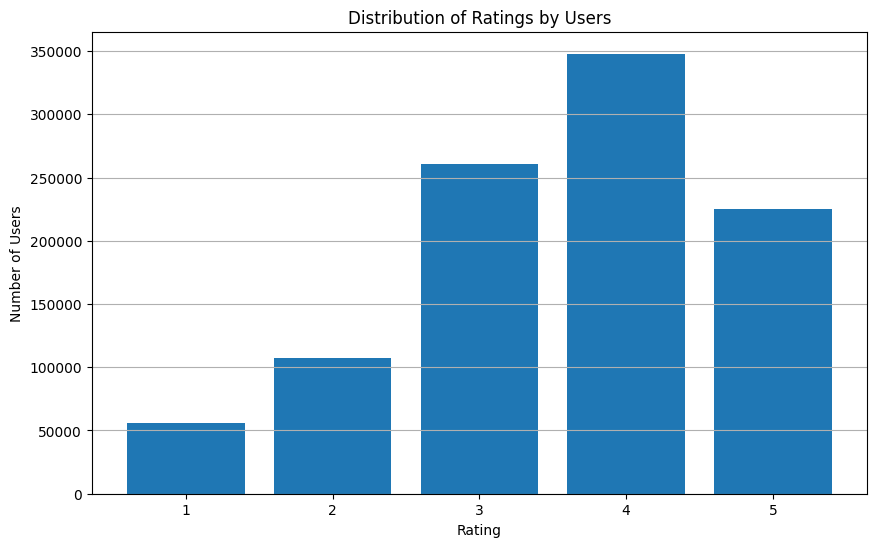

In [53]:

# Count the number of occurrences of each rating
rating_counts = final_df_copy['Rating'].value_counts().sort_index()

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.title('Distribution of Ratings by Users')
plt.xlabel('Rating')
plt.ylabel('Number of Users')
plt.xticks(range(1, 6))  # Set x-axis ticks from 1 to 5
plt.grid(axis='y')  # Show grid lines on the y-axis
plt.show()


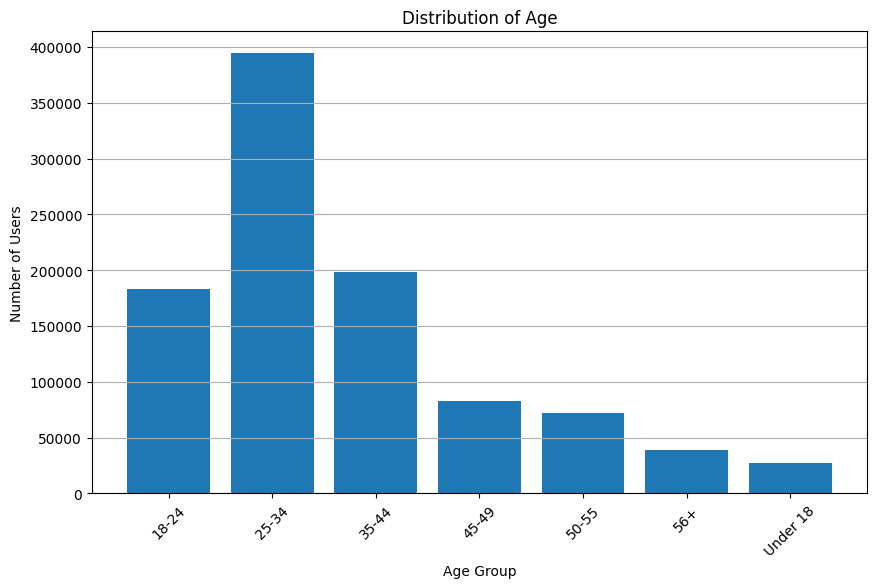

In [54]:

# Count the number of occurrences of each age group
age_counts = final_df_copy['Age'].value_counts().sort_index()

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(age_counts.index, age_counts.values)
plt.title('Distribution of Age')
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Show grid lines on the y-axis
plt.show()


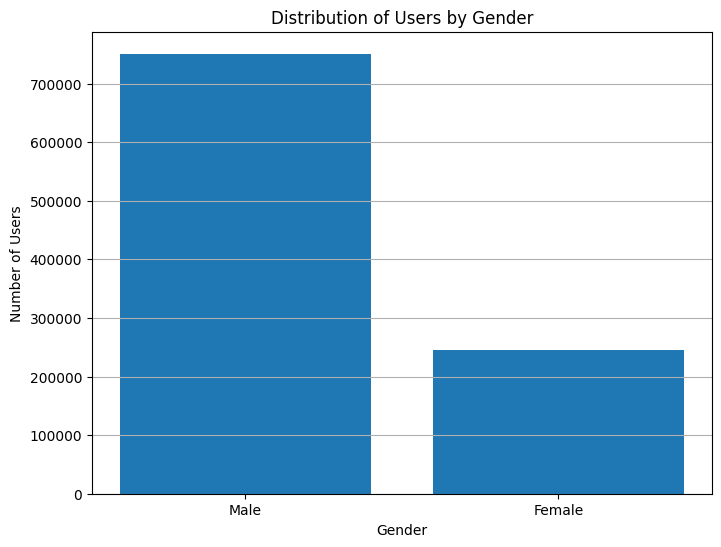

In [55]:


# Count the number of occurrences of each gender
gender_counts = final_df_copy['Gender'].value_counts()

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values)
plt.title('Distribution of Users by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.grid(axis='y')  # Show grid lines on the y-axis
plt.show()


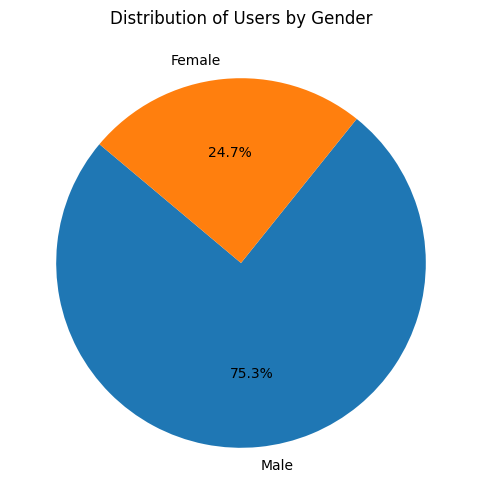

In [56]:


# Count the number of occurrences of each gender
gender_counts = final_df_copy['Gender'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Users by Gender')
plt.show()


In [59]:
users.Gender.value_counts()


Gender
Male      4331
Female    1709
Name: count, dtype: int64

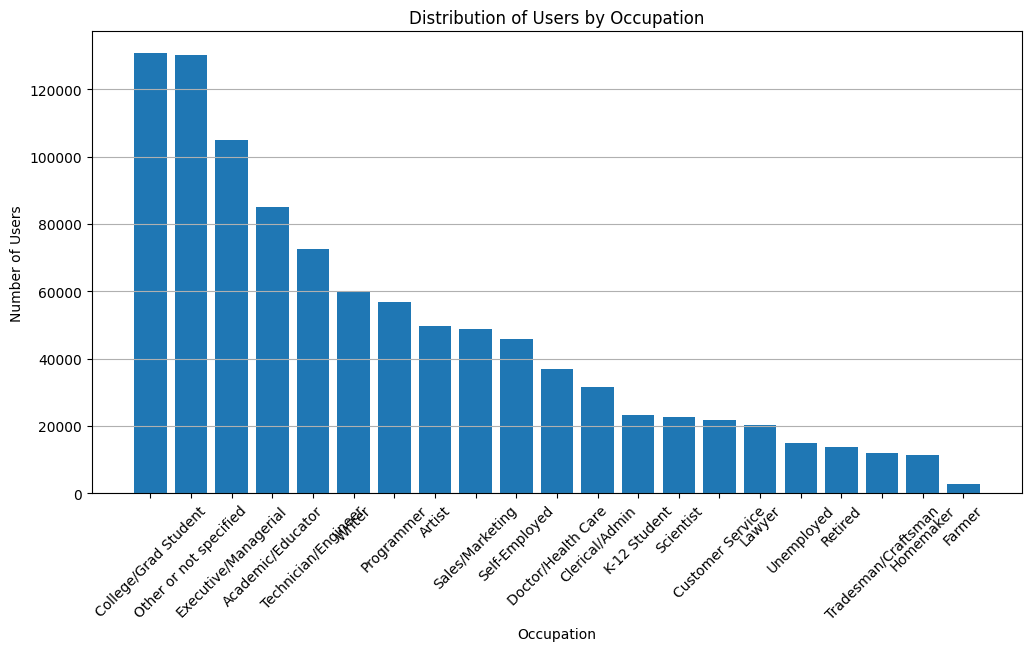

In [60]:
# Count the number of occurrences of each occupation
occupation_counts = final_df_copy['Occupation'].value_counts()

# Plotting the graph
plt.figure(figsize=(12, 6))
plt.bar(occupation_counts.index, occupation_counts.values)
plt.title('Distribution of Users by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Show grid lines on the y-axis
plt.show()

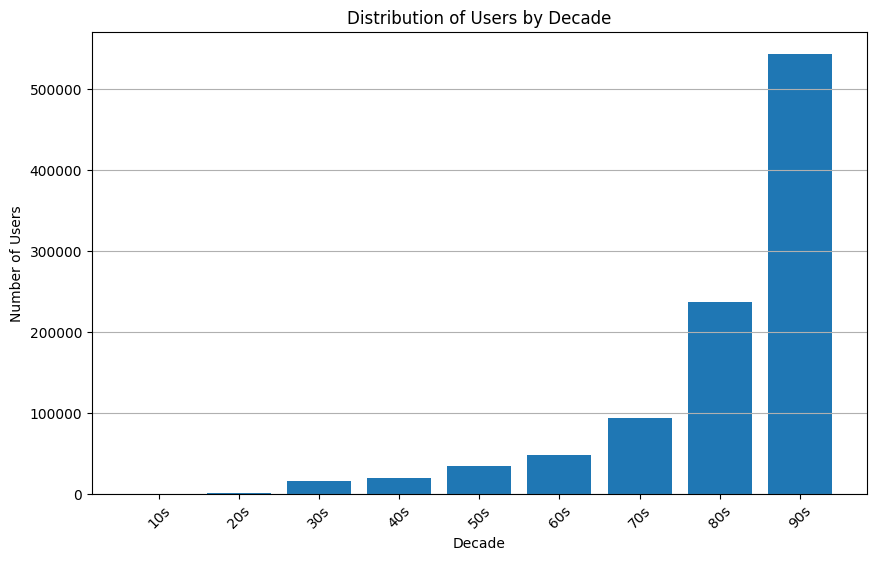

In [65]:
# Count the number of occurrences of each decade
decade_counts = final_df_copy['Decade'].value_counts().sort_index()

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(decade_counts.index, decade_counts.values)
plt.title('Distribution of Users by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Show grid lines on the y-axis
plt.show()

In [62]:
final_df_copy['Decade'].value_counts()

Decade
90s        542930
80s        237476
70s         94218
60s         48005
50s         35556
40s         19660
30s         16697
20s          2054
Unknown        69
Name: count, dtype: int64

In [63]:
# Define a function to map release years to decades
def map_to_decade(year):
    if year > 1910 and year <= 1920:
        return '10s'
    elif year > 1920 and year <= 1930:
        return '20s'
    elif year > 1930 and year <= 1940:
        return '30s'
    elif year > 1940 and year <= 1950:
        return '40s'
    elif year > 1950 and year <= 1960:
        return '50s'
    elif year > 1960 and year <= 1970:
        return '60s'
    elif year > 1970 and year <= 1980:
        return '70s'
    elif year > 1980 and year <= 1990:
        return '80s'
    elif year > 1990 and year <= 2000:
        return '90s'
    elif year > 2000 and year <= 2010:
        return '2000s'
    else:
        return 'Unknown'

# Apply the function to create the 'Decade' column
final_df_copy['Decade'] = final_df_copy['ReleaseYear'].apply(map_to_decade)



In [64]:
final_df_copy['Decade'].value_counts()

Decade
90s    542930
80s    237476
70s     94218
60s     48005
50s     35556
40s     19660
30s     16697
20s      2054
10s        69
Name: count, dtype: int64

## Group the data according to the average rating and no. of ratings

In [74]:

# Group by 'Title' and calculate aggregate statistics
title_stats = final_df_copy.groupby('Title').agg({'Rating': 'mean', 'Rating': 'count'}).rename(columns={'Rating': 'No. of ratings'}).reset_index()
title_stats['Avg rating'] = final_df_copy.groupby('Title')['Rating'].mean().round(2).values

# Display the new dataframe
(title_stats.head(10))  # Show the first 10 rows for demonstration


,Title,No. of ratings,Avg rating
0,"$1,000,000 Duck",37,3.03
1,'Night Mother,70,3.37
2,'Til There Was You,52,2.69
3,"'burbs, The",303,2.91
4,...And Justice for All,199,3.71
5,1-900,2,2.50
6,10 Things I Hate About You,700,3.42
7,101 Dalmatians,929,3.38
8,12 Angry Men,616,4.30
9,"13th Warrior, The",750,3.16


In [75]:
title_stats[title_stats['Title']=='Judgment Night']

,Title,No. of ratings,Avg rating
1746,Judgment Night,133,2.8


## Creating a pivot table of movie titles & user id and imputing the NaN values

In [76]:


# Create a pivot table of UserID as index, titles as columns, and values as ratings
pivot_table = pd.pivot_table(final_df_copy, values='Rating', index='UserID', columns='Title', aggfunc='mean', fill_value=0)

# Display the pivot tab
(pivot_table.head())


Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin,Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0


In [77]:
pivot_table.shape

(6040, 3639)

In [81]:
movie_name = input("Enter a movie name: ")
movie_rating = pivot_table[movie_name]


Enter a movie name: Liar Liar


## Use the Item-based approach to create a simple recommender system that uses Pearson Correlation

In [83]:
similar_movies = pivot_table.corrwith(movie_rating)

In [84]:
sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True)

In [85]:
sim_df.iloc[1: , :].head()

,Correlation
Title,
Mrs. Doubtfire,0.499927
Dumb & Dumber,0.459601
Ace Ventura: Pet Detective,0.458654
Home Alone,0.455967
"Wedding Singer, The",0.429222


## Print the user similarity matrix and item similarity matrix

In [86]:
# Create a pivot table of movies and user ratings
pivot_table_cos = pd.pivot_table(final_df_copy, values='Rating', index='UserID', columns='Title', fill_value=0)

# Calculate cosine similarity for item-item similarity based on movie titles
item_similarity = cosine_similarity(pivot_table_cos.T)

# Create a dataframe of item-item similarity
item_similarity_df = pd.DataFrame(item_similarity, index=pivot_table_cos.columns, columns=pivot_table_cos.columns)

# Display the item-item similarity dataframe
(item_similarity_df.head())


Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin,Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


In [87]:
# Calculate cosine similarity for user-user similarity based on user ratings
user_similarity = cosine_similarity(pivot_table_cos)

# Create a dataframe of user-user similarity
user_similarity_df = pd.DataFrame(user_similarity, index=pivot_table_cos.index, columns=pivot_table_cos.index)

# Display the user-user similarity dataframe
(user_similarity_df.head())


UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255319,0.123967,0.207800,0.139317,0.110320,0.121384,0.180226,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.255319,1.000000,0.259645,0.280479,0.158703,0.112917,0.141985,0.432536,0.194915,0.102487,...,0.154412,0.186234,0.083739,0.125894,0.118558,0.146552,0.304806,0.165700,0.133327,0.248450
100,0.123967,0.259645,1.000000,0.306067,0.075736,0.110450,0.358686,0.237492,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.280479,0.306067,1.000000,0.099117,0.047677,0.201722,0.355920,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139317,0.158703,0.075736,0.099117,1.000000,0.164854,0.053887,0.152057,0.138602,0.134710,...,0.146270,0.026891,0.097011,0.119609,0.092234,0.109700,0.222119,0.103255,0.269952,0.178399


## Use the Item-based approach to create a recommender system that uses Nearest Neighbors algorithm and Cosine Similarity

In [91]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Create a sparse matrix using the CSR format
sparse_matrix = csr_matrix(pivot_table_cos.T.values)

# Fit the Nearest Neighbors model using Cosine Similarity
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_matrix)

# Get input movie name from the user
movie_name = input("Enter the name of a movie: ")

# Find the index of the input movie in the pivot table
movie_index = pivot_table_cos.columns.get_loc(movie_name)

# Find the 6 nearest neighbors (including the input movie itself)
distances, indices = model.kneighbors(sparse_matrix[movie_index], n_neighbors=6)

# Get the indices of the recommended movies (excluding the input movie itself)
recommended_indices = indices.flatten()[1:]

# Get the titles of the recommended movies
recommended_movies = pivot_table_cos.columns[recommended_indices]

# Display the top 5 recommended movies
print("Top 5 recommended movies similar to", movie_name)
for i, movie in enumerate(recommended_movies[:5], 1):
    print(i, "-", movie)


Enter the name of a movie: Liar Liar
Top 5 recommended movies similar to Liar Liar
1 - Mrs. Doubtfire
2 - Ace Ventura: Pet Detective
3 - Dumb & Dumber
4 - Home Alone
5 - Wayne's World


## Create a Recommender System using the Matrix Factorization method

In [95]:
!pip install cmfrec

  Using cached cmfrec-3.5.1.post8.tar.gz (268 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached findblas-0.1.23-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post8-cp311-cp311-win_amd64.whl size=1068419 sha256=0ed70e0deaae88950d08c7182bd748f512160e912917783c2d89bfe95af805a7
  Stored in directory: c:\users\sharat\appdata\local\pip\cache\wheels\54\37\84\f768850e8861afeedd63dacbfc9eedd23c62310a6852d53a2c
Successfully built cmfrec


In [101]:

from sklearn.model_selection import train_test_split
from cmfrec import CMF

# Step 2: Load and preprocess the data
# Assuming you have a DataFrame named final_df_copy with columns UserID, MovieID, and Rating
data = final_df_copy[['UserID', 'MovieID', 'Rating']]

# Step 3: Rename columns to match the expected format by CMF model
data.rename(columns={'UserID': 'UserId', 'MovieID': 'ItemId'}, inplace=True)

# Step 4: Split the data into training and testing sets for Matrix Factorization
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Step 5: Train the Matrix Factorization model with d=4 embeddings
model = CMF(k=4, random_state=42, niter=100)
model.fit(train_data)

# Step 6: Evaluate the model's performance using RMSE and MAPE
predictions = []
for _, row in test_data.iterrows():
    user_id, item_id = row['UserId'], row['ItemId']
    pred_rating = model.predict(user=user_id, item=item_id)
    predictions.append(pred_rating)

predictions = np.array(predictions)
rmse = np.sqrt(np.mean((test_data['Rating'] - predictions)**2))
mape = np.mean(np.abs(test_data['Rating'] - predictions) / test_data['Rating']) * 100

print("RMSE:", rmse)
print("MAPE:", mape)

# Step 7: Use the learned embeddings for visualization and similarity-based models
user_embeddings = model.U_
item_embeddings = model.V_

# Step 8: Redesign item-item and user-user similarity functions using MF embeddings
# For example, to compute cosine similarity between item embeddings
def item_item_similarity(item_id_1, item_id_2):
    emb_1 = item_embeddings[item_id_1]
    emb_2 = item_embeddings[item_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Similarly, compute user-user similarity using MF embeddings
def user_user_similarity(user_id_1, user_id_2):
    emb_1 = user_embeddings[user_id_1]
    emb_2 = user_embeddings[user_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Bonus: Get d=2 embeddings and plot the results
import matplotlib.pyplot as plt

model_2d = CMF(k=2, random_state=42, niter=100)
model_2d.fit(train_data)
item_embeddings_2d = model_2d.V_

plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('2D Embeddings Visualization')
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (199333,) + inhomogeneous part.

In [102]:
# Step 1: Install Surprise library
!pip install scikit-surprise

     ---------------------------------------- 0.0/772.0 kB ? eta -:--:--
     ------------ ------------------------- 256.0/772.0 kB 5.2 MB/s eta 0:00:01
     -------------------------------------  768.0/772.0 kB 9.7 MB/s eta 0:00:01
     -------------------------------------- 772.0/772.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp311-cp311-win_amd64.whl size=1295298 sha256=9729a909c940bc53859aac3b348556b89e537cf5cbef9055cc55ee27b0d4ce81
  Stored in directory: c:\users\sharat\appdata\local\pip\cache\wheels\f4\2b\26\e2a5eae55d3b7688995e66abe7f40473aac6c95ddd8ee174a8
Successfully built scikit-surprise


## Evaluate the model in terms of the Root Mean Squared Error and Mean Absolute Percentage Error

In [103]:
# Step 2: Import necessary modules from Surprise
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# Step 3: Load your dataset into Surprise
# Assuming you have a DataFrame named final_df_copy with columns UserID, MovieID, and Rating
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(final_df_copy[['UserID', 'MovieID', 'Rating']], reader)

# Step 4: Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Step 5: Train the Matrix Factorization model (SVD) on the training set
model = SVD(n_factors=4, random_state=42)
model.fit(trainset)

# Step 6: Make predictions on the test set
predictions = model.test(testset)

# Step 7: Evaluate the model's performance using RMSE
rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)


RMSE: 0.8842
RMSE: 0.8842343257986099


In [107]:
# Step 12: Make predictions using the trained SVD model
predictions = [model.predict(uid, iid, r_ui_trans) for (uid, iid, r_ui_trans) in test_data.itertuples(index=False)]

# Step 13: Compute absolute percentage error for each prediction
absolute_percentage_errors = []
for prediction in predictions:
    actual_rating = prediction.r_ui
    predicted_rating = prediction.est
    absolute_percentage_error = abs((actual_rating - predicted_rating) / actual_rating) 
    absolute_percentage_errors.append(absolute_percentage_error)

# Step 14: Calculate MAPE
mape = np.mean(absolute_percentage_errors)

print("MAPE:", mape)



MAPE: 0.2612327752643904


## Use embeddings for visualization and similarity-based models.

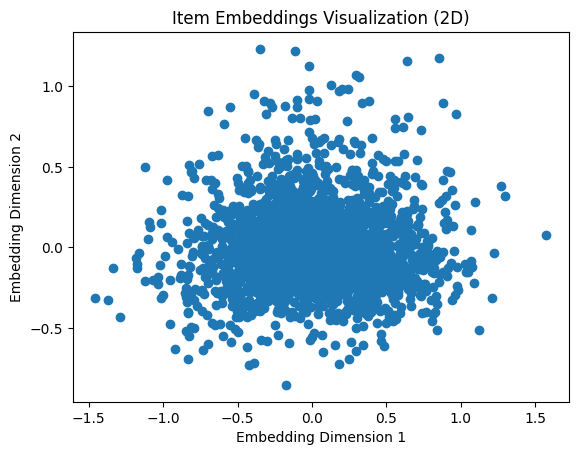

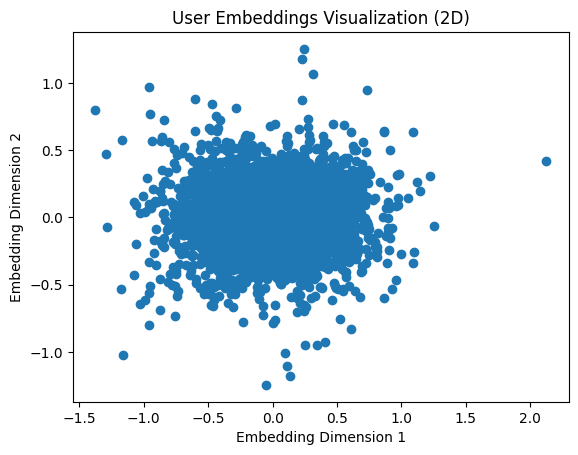

In [104]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 8: Extract item and user embeddings from the trained SVD model
item_embeddings = model.qi
user_embeddings = model.pu

# Step 9: Redesign item-item similarity function using MF embeddings
def item_item_similarity(item_id_1, item_id_2):
    emb_1 = item_embeddings[item_id_1]
    emb_2 = item_embeddings[item_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Step 10: Redesign user-user similarity function using MF embeddings
def user_user_similarity(user_id_1, user_id_2):
    emb_1 = user_embeddings[user_id_1]
    emb_2 = user_embeddings[user_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Step 11: Bonus - Get d=2 embeddings and plot the results
pca = PCA(n_components=2)
item_embeddings_2d = pca.fit_transform(item_embeddings)
user_embeddings_2d = pca.fit_transform(user_embeddings)

# Plot item embeddings in 2D
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Item Embeddings Visualization (2D)')
plt.show()

# Plot user embeddings in 2D
plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('User Embeddings Visualization (2D)')
plt.show()


In [108]:
# Assuming your old dataframe is named final_df_copy
max_rated_movie = final_df_copy.groupby('Title')['Rating'].count().idxmax()
max_rating_count = final_df_copy.groupby('Title')['Rating'].count().max()

print("Movie with maximum ratings:")
print("Title:", max_rated_movie)
print("Number of Ratings:", max_rating_count)


Movie with maximum ratings:
Title: American Beauty
Number of Ratings: 3428
